## Mobile Flight Booking System 

In [9]:
# import the required libraries 
import pandas as pd

data = pd.read_csv("/kaggle/input/mobile-flight-booking-system-survey/survey-data.csv")

data.head()

# print(data)


,Timestamp,Gender,Age,How frequently do you use mobile flight booking applications?,How easy do you find it to navigate through mobile flight booking applications?,How satisfied are you with the clarity of information provided during flight booking process?,"Do you often struggle to find flights that match your preferences like times, stops, airlines by using app's search function ?","Do you find the details provided for flights like layover duration, baggage fees, total travel time not clear ?",Do you find the process to select a flight and proceed to booking is overly complicated ?,\nDo you find that final price at checkout often includes unexpected charges ?,...,The app does not offer personalized flight recommendations based on my previous bookings.,Flight booking apps do not sufficiently support accessibility features for users with disabilities.,Do you find the mobile check-in process is complicated.,How likely are you to use a voice-activated interface for searching and booking flights within a mobile app?,How do you prioritize features of mobile flight booking application? Choose from most to least priority features. [1],How do you prioritize features of mobile flight booking application? Choose from most to least priority features. [2],How do you prioritize features of mobile flight booking application? Choose from most to least priority features. [3],How do you prioritize features of mobile flight booking application? Choose from most to least priority features. [4],How do you prioritize features of mobile flight booking application? Choose from most to least priority features. [5],What improvements or changes would you suggest to enhance your experience with the mobile flight booking application ?
0,2024/04/14 7:57:54 PM GMT+1,Male,26-35,Sometimes,Somewhat difficult,Somewhat dissatisfied,Agree,Agree,Agree,Agree,...,Strongly Agree,Agree,Agree,Likely,Simplified Booking Process,Information Clarity,Personalization,Performance,Easy Navigation,Make the search process easier with a clear an...
1,2024/04/14 8:41:15 PM GMT+1,Male,36-45,Sometimes,Somewhat easy,Neutral,Agree,Agree,Strongly Agree,Agree,...,Disagree,Agree,Agree,Highly likely,Easy Navigation,Information Clarity,Performance,Simplified Booking Process,Personalization,NaN
2,2024/04/16 4:51:30 PM GMT+1,Male,36-45,Sometimes,Somewhat easy,Extremely satisfied,Strongly Agree,Strongly Disagree,Strongly Disagree,Agree,...,Disagree,Neutral,Strongly Disagree,Likely,Information Clarity,Simplified Booking Process,Personalization,Performance,Easy Navigation,Mostly some features are not available on mobi...
3,2024/04/16 5:03:00 PM GMT+1,Male,26-35,Sometimes,Very difficult,Extremely dissatisfied,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,...,Neutral,Agree,Agree,Unlikely,Easy Navigation,Simplified Booking Process,Information Clarity,Performance,Personalization,Please provide easy to use platform because co...
4,2024/04/16 6:05:54 PM GMT+1,Male,26-35,Sometimes,Very easy,Somewhat satisfied,Agree,Agree,Agree,Neutral,...,Agree,Neutral,Neutral,Likely,Easy Navigation,Information Clarity,Performance,Simplified Booking Process,Personalization,NaN


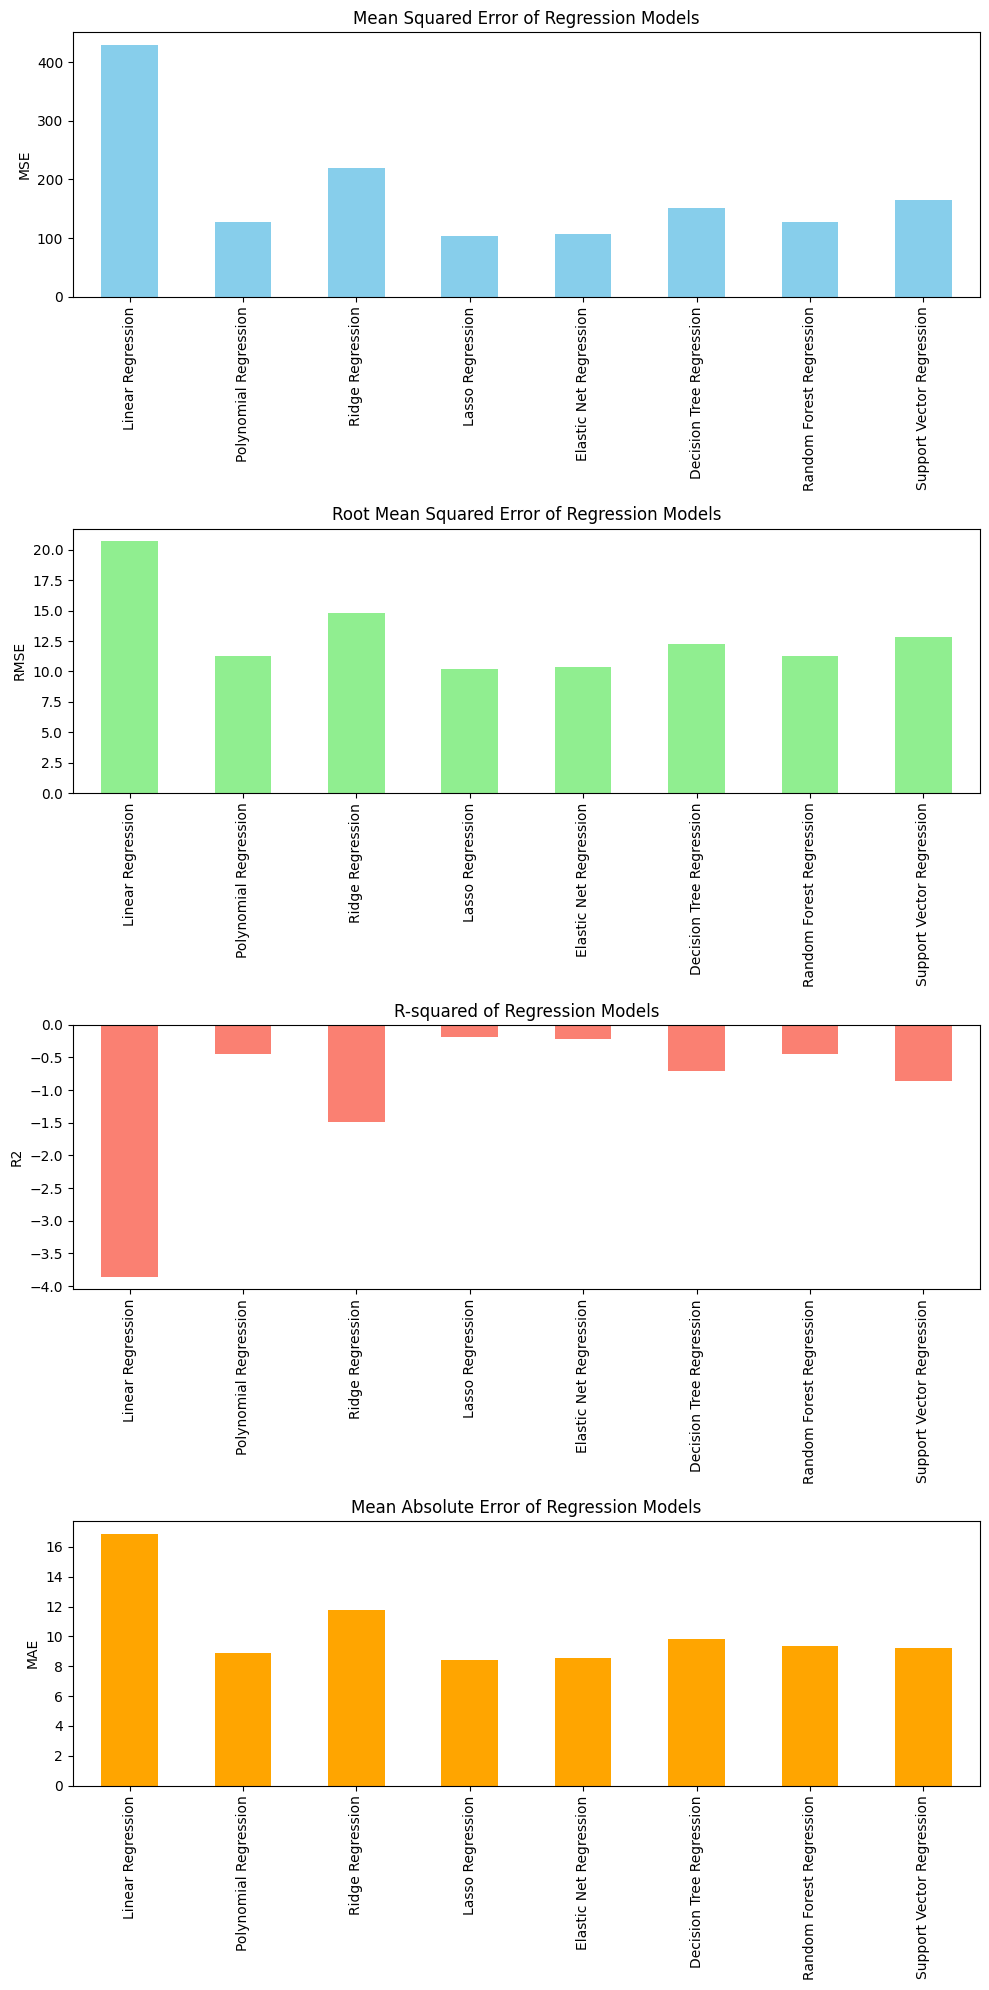

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the dataset
file_path = '/kaggle/input/mobile-flight-booking-system-survey/survey-data.csv'
data = pd.read_csv(file_path)

# Remove leading and trailing spaces from column names
data.columns = data.columns.str.strip()

# Map 'Age' column to numerical values
age_mapping = {
    'Under 18': 1, 
    '18-25': 2, 
    '26-35': 3, 
    '36-45': 4, 
    '46-55': 5, 
    '56-65': 6, 
    'Over 65': 7,
    '46 and above': 8  # Added based on the unique values found
}
data['Age'] = data['Age'].map(age_mapping)

# Dropping rows with non-numeric values in 'Age' column
data = data.dropna(subset=['Age'])

# Selecting numerical and categorical columns
num_cols = ['Age']
cat_cols = [col for col in data.columns if col not in num_cols and col != 'Timestamp' and col != data.columns[-1]]

# Preprocessing for numerical data
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)])

# Encode the target variable if it is categorical
target_col = data.columns[-1]
if data[target_col].dtype == 'object':
    label_encoder = LabelEncoder()
    data[target_col] = label_encoder.fit_transform(data[target_col].astype(str))

# Define a function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, rmse, r2, mae

# Splitting the data into features and target variable
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Handling missing values in the target variable
y = y.fillna(y.mode()[0])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying different regression models
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression())]),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Support Vector Regression': SVR()
}

# Apply preprocessor and train models
results = {}
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    clf.fit(X_train, y_train)
    mse, rmse, r2, mae = evaluate_model(clf, X_test, y_test)
    results[name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAE': mae}

# Converting results to DataFrame
results_df = pd.DataFrame(results).T

# Visualizing the results
import matplotlib.pyplot as plt

# Plotting evaluation metrics for each model
fig, ax = plt.subplots(4, 1, figsize=(10, 20))

# Plotting Mean Squared Error
results_df['MSE'].plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Mean Squared Error of Regression Models')
ax[0].set_ylabel('MSE')

# Plotting Root Mean Squared Error
results_df['RMSE'].plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title('Root Mean Squared Error of Regression Models')
ax[1].set_ylabel('RMSE')

# Plotting R-squared
results_df['R2'].plot(kind='bar', ax=ax[2], color='salmon')
ax[2].set_title('R-squared of Regression Models')
ax[2].set_ylabel('R2')

# Plotting Mean Absolute Error
results_df['MAE'].plot(kind='bar', ax=ax[3], color='orange')
ax[3].set_title('Mean Absolute Error of Regression Models')
ax[3].set_ylabel('MAE')

# Display the plots
plt.tight_layout()
plt.show()
